In [2]:
!pip uninstall torch torchvision torchaudio -y
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Successfully uninstalled torch-2.8.0+cu126
Found existing installation: torchvision 0.23.0+cu126
Uninstalling torchvision-0.23.0+cu126:
  Successfully uninstalled torchvision-0.23.0+cu126
Found existing installation: torchaudio 2.8.0+cu126
Uninstalling torchaudio-2.8.0+cu126:
  Successfully uninstalled torchaudio-2.8.0+cu126
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 103.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 124.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5

In [4]:
# Install necessary libraries
!pip install transformers timm torch-lr-scheduler -q

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from transformers import ViTForImageClassification, ViTFeatureExtractor
from PIL import Image
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Custom Dataset Class
class SkinDiseaseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []

        for class_idx, class_name in enumerate(sorted(os.listdir(root_dir))):
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    self.data.append(img_path)
                    self.labels.append(class_idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Define Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Paths
train_dir = '/content/drive/MyDrive/NEWDATASET/NEWDATASET/train'
test_dir = '/content/drive/MyDrive/NEWDATASET/NEWDATASET/test'

# Load Data
train_dataset = SkinDiseaseDataset(train_dir, transform=transform)
test_dataset = SkinDiseaseDataset(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Load Pretrained Vision Transformer
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=5  # Number of classes
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Training Loop
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Loss: 0.9437
Epoch 2/5, Loss: 0.4744
Epoch 3/5, Loss: 0.2387
Epoch 4/5, Loss: 0.1309
Epoch 5/5, Loss: 0.1155
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       261
           1       0.74      0.68      0.71       352
           2       0.88      0.81      0.85       343
           3       0.76      0.77      0.76       325
           4       0.73      0.86      0.79       272

    accuracy                           0.79      1553
   macro avg       0.80      0.80      0.80      1553
weighted avg       0.79      0.79      0.79      1553



In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Convert predictions and labels to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute overall accuracy
overall_accuracy = accuracy_score(all_labels, all_preds)
print(f"Overall Accuracy: {overall_accuracy:.4f}")

# Compute class-wise accuracy
num_classes = len(set(all_labels))  # Assuming all classes are present in test set
class_accuracies = {}

for class_idx in range(num_classes):
    class_mask = all_labels == class_idx  # Get indices where label == class_idx
    class_acc = accuracy_score(all_labels[class_mask], all_preds[class_mask])
    class_accuracies[class_idx] = class_acc

print("\nClass-wise Accuracy:")
for class_idx, acc in class_accuracies.items():
    print(f"Class {class_idx}: {acc:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))


Overall Accuracy: 0.7920

Class-wise Accuracy:
Class 0: 0.8736
Class 1: 0.6818
Class 2: 0.8134
Class 3: 0.7692
Class 4: 0.8566

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       261
           1       0.74      0.68      0.71       352
           2       0.88      0.81      0.85       343
           3       0.76      0.77      0.76       325
           4       0.73      0.86      0.79       272

    accuracy                           0.79      1553
   macro avg       0.80      0.80      0.80      1553
weighted avg       0.79      0.79      0.79      1553



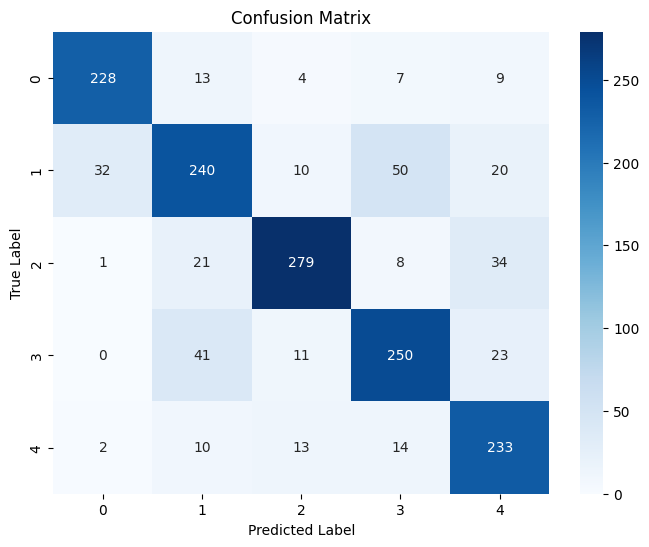

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [28]:
all_logits = []  # Store raw logits
all_labels = []  # Store true labels

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits  # Get raw logits
        all_logits.extend(outputs.cpu().numpy())  # Store logits
        all_labels.extend(labels.cpu().numpy())  # Store true labels

# Convert to NumPy arrays
all_logits = np.array(all_logits)
all_labels = np.array(all_labels)


In [29]:
y_pred_probs = torch.nn.functional.softmax(torch.tensor(all_logits), dim=1).numpy()


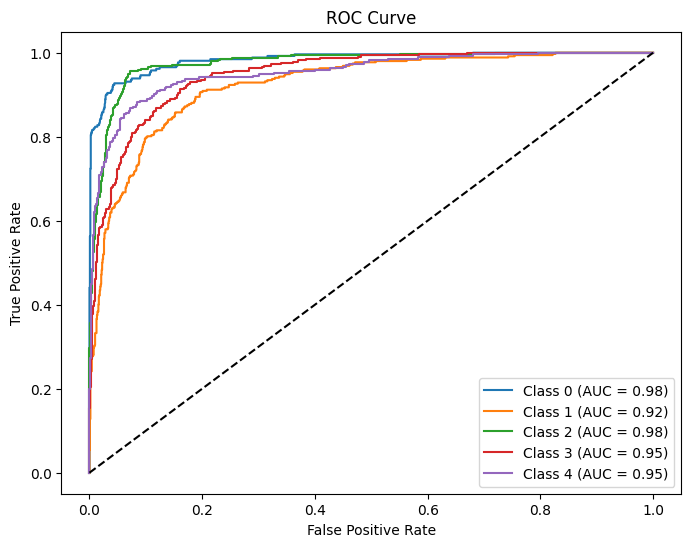

In [30]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

num_classes = all_logits.shape[1]  # Get number of classes

# Binarize labels for multi-class ROC
y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))

# Plot ROC curve
plt.figure(figsize=(8, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random classifier)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


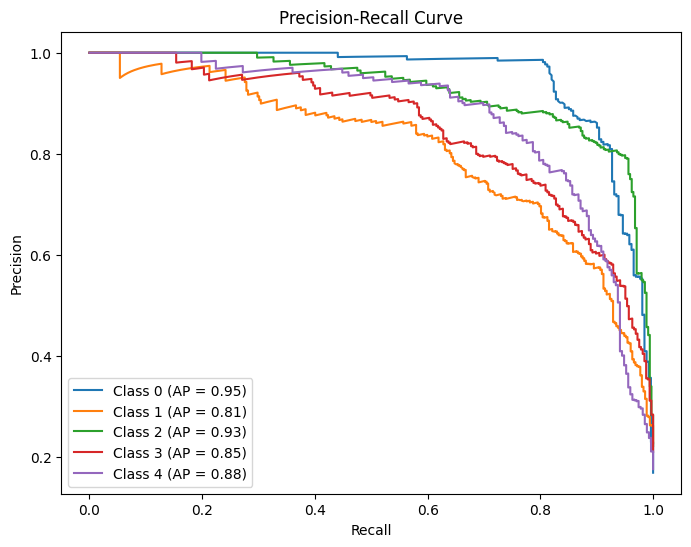

In [31]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8, 6))

for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_probs[:, i])
    avg_precision = average_precision_score(y_true_bin[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, label=f"Class {i} (AP = {avg_precision:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


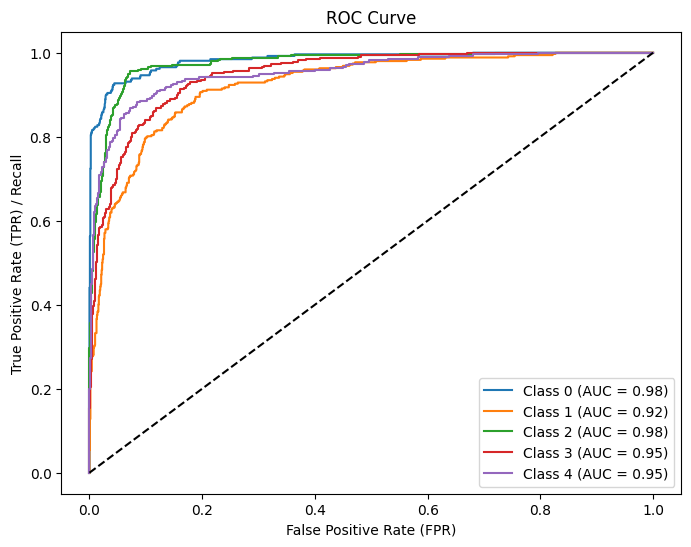

In [34]:
plt.figure(figsize=(8, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR) / Recall")
plt.title("ROC Curve")
plt.legend()
plt.show()


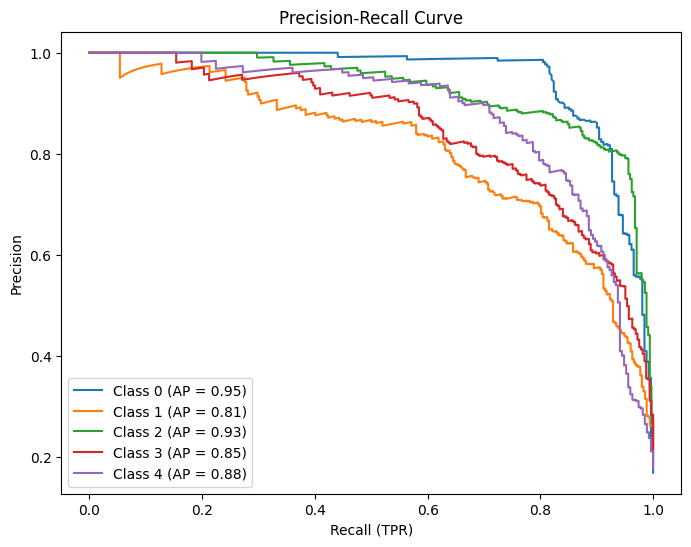

In [35]:
plt.figure(figsize=(8, 6))

for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_probs[:, i])
    avg_precision = average_precision_score(y_true_bin[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, label=f"Class {i} (AP = {avg_precision:.2f})")

plt.xlabel("Recall (TPR)")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


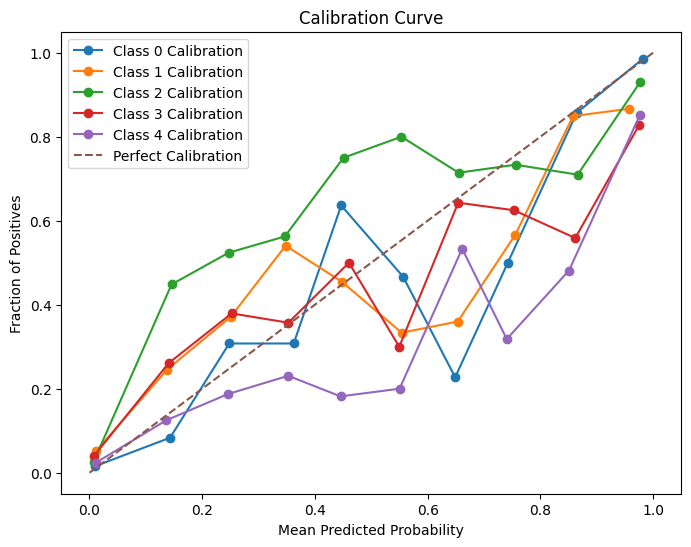

In [36]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import label_binarize

# Compute calibration curve (probability vs actual correctness)
plt.figure(figsize=(8, 6))

# Binarize labels for multi-class calibration
y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))

for i in range(num_classes):
    prob_true, prob_pred = calibration_curve(y_true_bin[:, i], y_pred_probs[:, i], n_bins=10, strategy='uniform')
    plt.plot(prob_pred, prob_true, marker='o', label=f"Class {i} Calibration")

# Plot perfectly calibrated line
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve")
plt.legend()
plt.show()

In [37]:
misclassified_samples = []
misclassified_labels = []
misclassified_preds = []

# Convert logits to predicted labels
all_preds = np.argmax(y_pred_probs, axis=1)

# Find misclassified indexes
misclassified_idxs = np.where(all_preds != all_labels)[0]

# Store misclassified samples
for idx in misclassified_idxs[:10]:  # Limit to first 10 samples for visualization
    misclassified_samples.append(test_dataset[idx][0])  # Image
    misclassified_labels.append(all_labels[idx])  # True label
    misclassified_preds.append(all_preds[idx])  # Predicted label


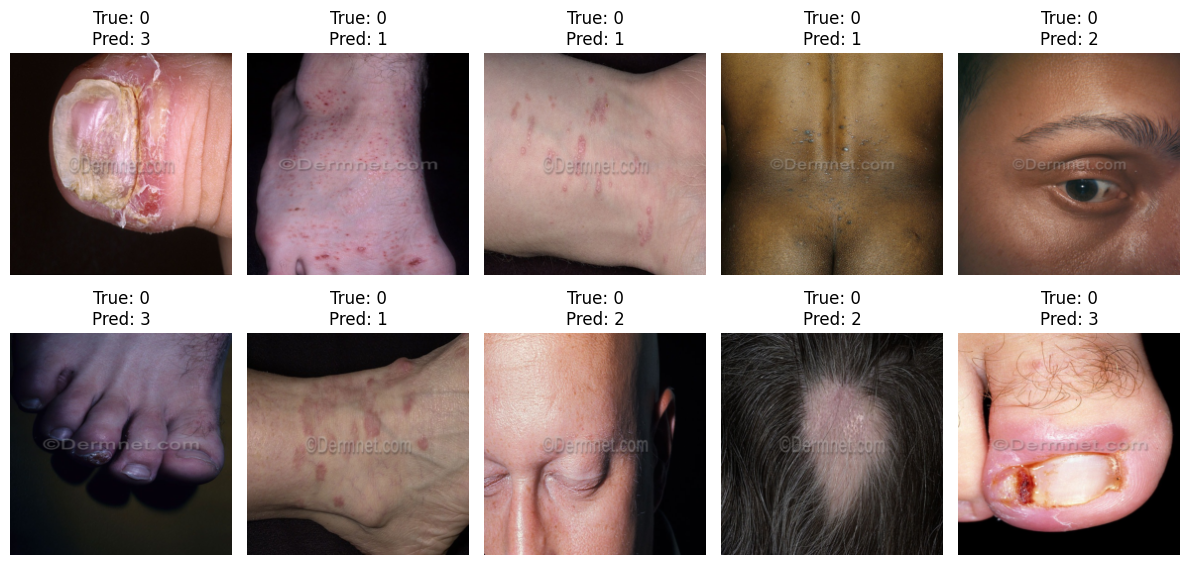

In [38]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(12, 6))  # Create a 2-row, 5-column grid

for i, ax in enumerate(axes.flat):
    if i < len(misclassified_samples):
        img = misclassified_samples[i].permute(1, 2, 0).numpy()  # Convert tensor to NumPy
        ax.imshow((img * 0.5) + 0.5)  # Unnormalize
        ax.set_title(f"True: {misclassified_labels[i]}\nPred: {misclassified_preds[i]}")
        ax.axis("off")

plt.tight_layout()
plt.show()
